<a href="https://colab.research.google.com/github/poojitha-kandi/Kolam-AI/blob/main/Kolam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 1.jpg to 1.jpg
User uploaded file '1.jpg'
Original Image:


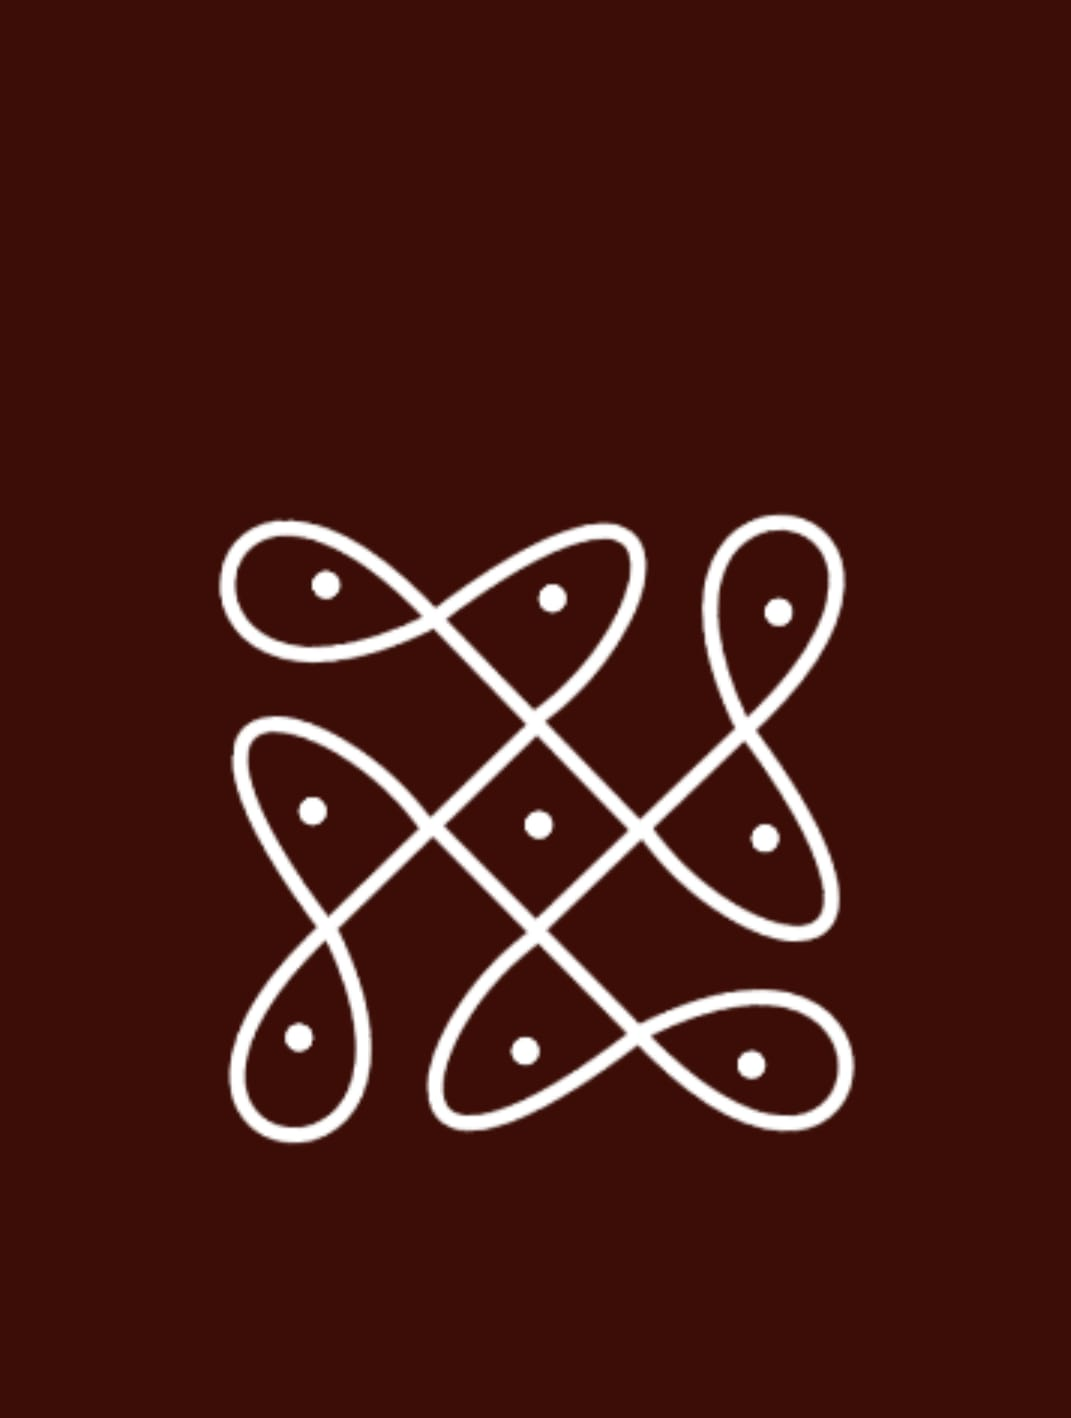

In [1]:
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# --- 1. Upload the image ---
uploaded = files.upload()

# Get the filename of the uploaded image
if len(uploaded.keys()) > 0:
    filename = list(uploaded.keys())[0]
    print(f"User uploaded file '{filename}'")

    # --- 2. Read and Display the Image ---
    # Read the image using OpenCV
    img = cv2.imread(filename)

    # Display the original image
    print("Original Image:")
    cv2_imshow(img)

else:
    print("No file was uploaded.")

Grayscale Image:


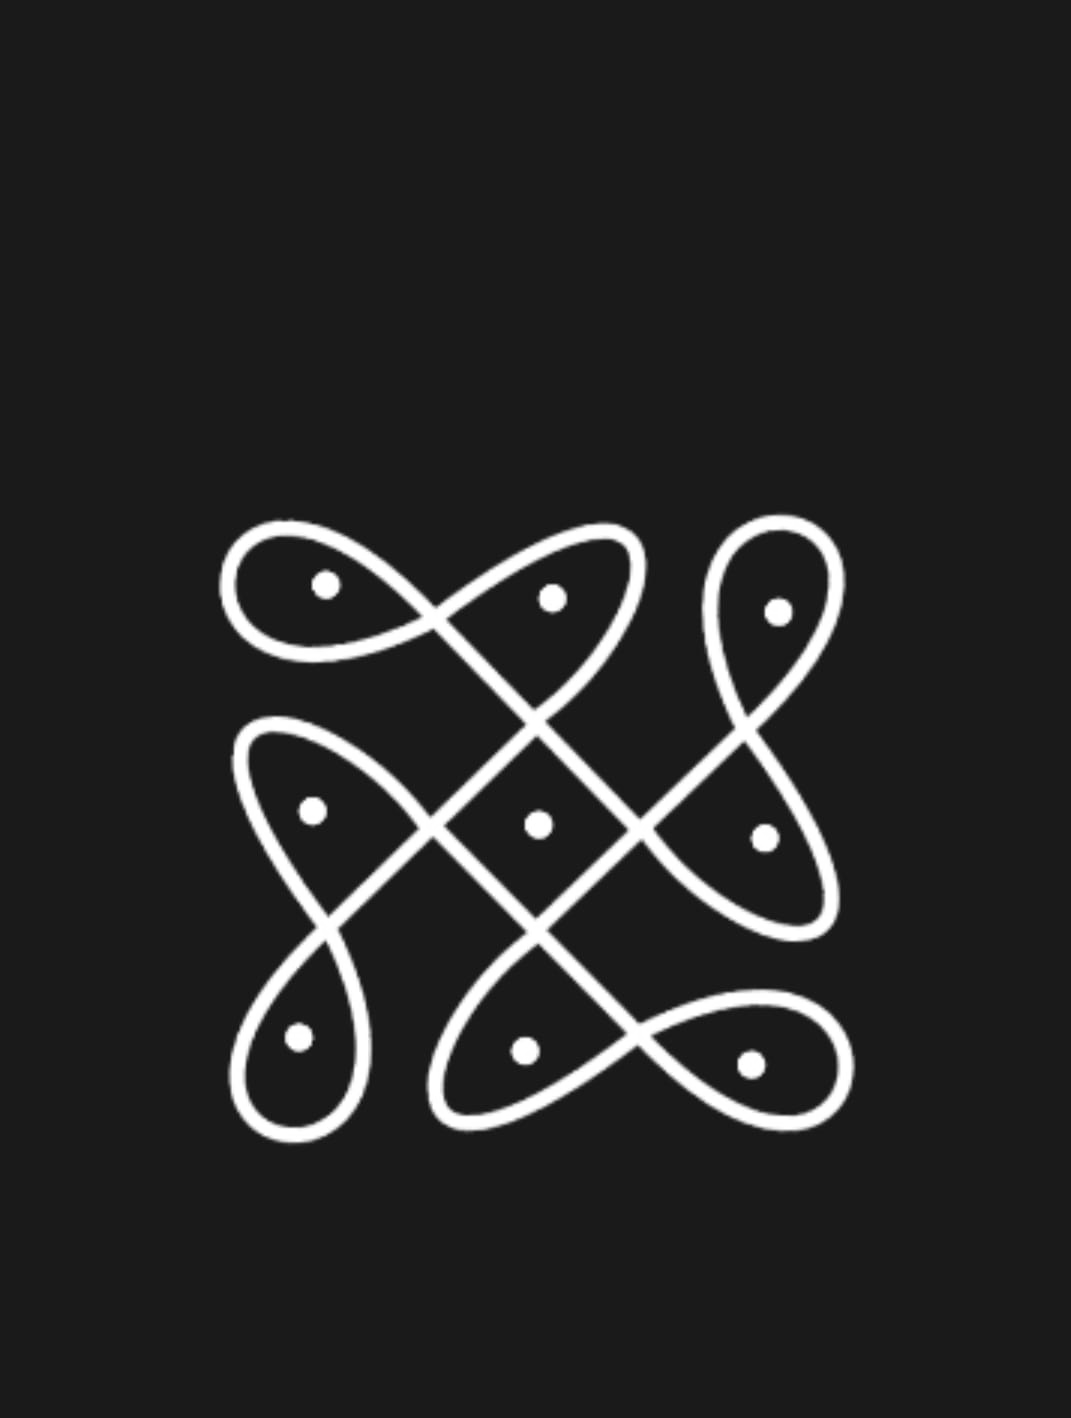


Black and White (Binary) Image:


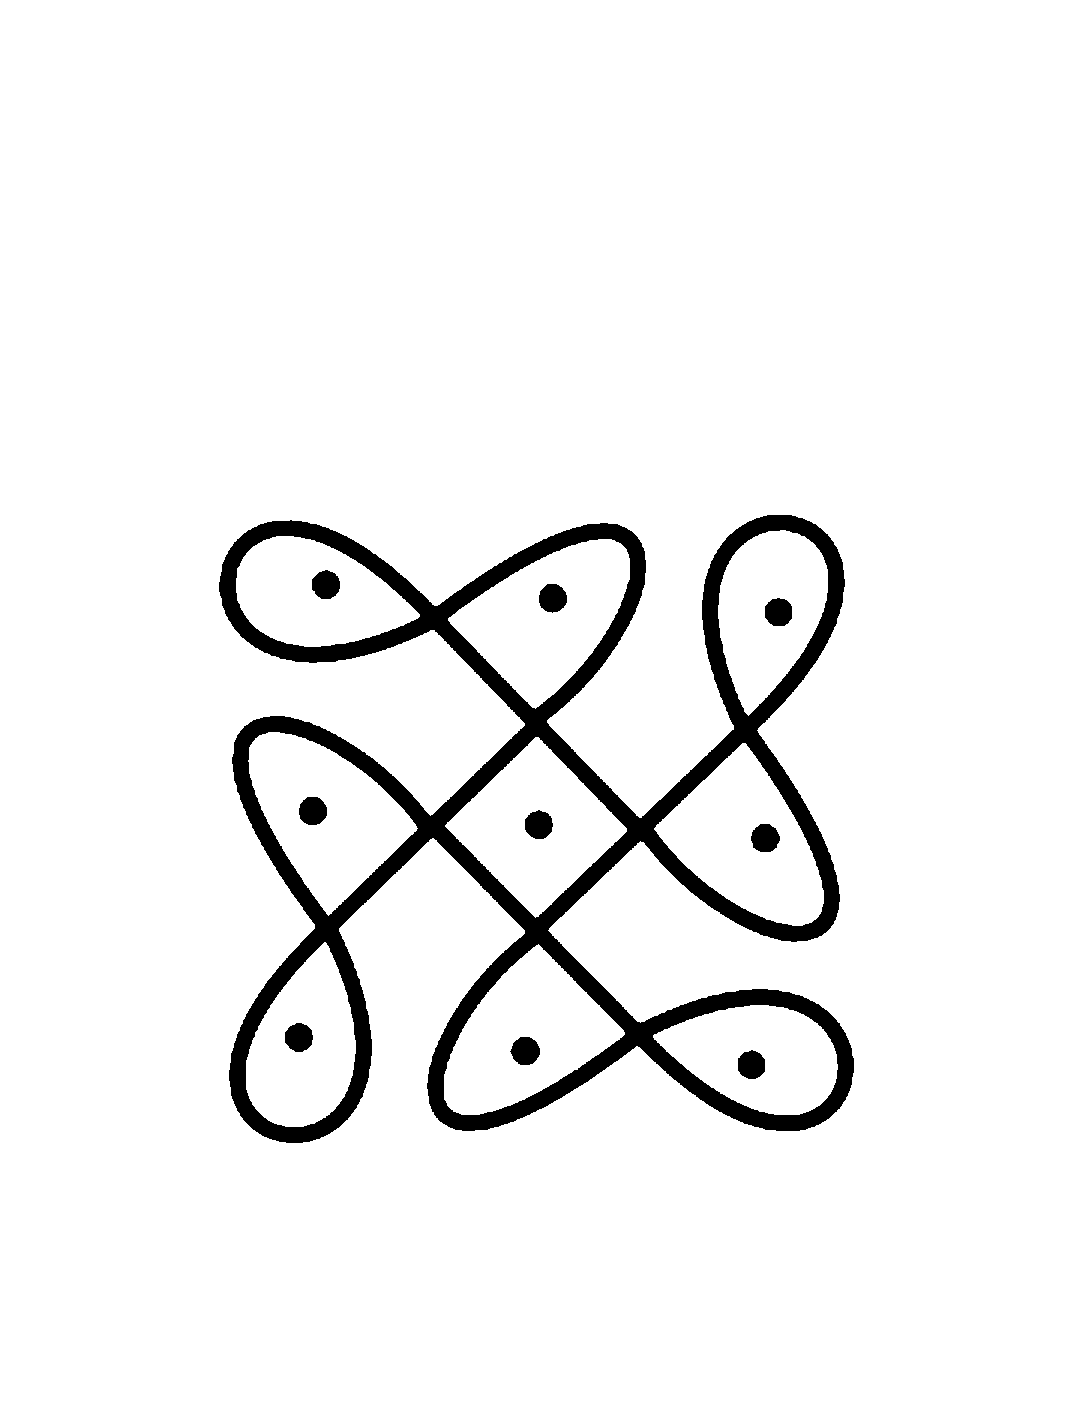

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# --- 1. Read the uploaded image ---
# Make sure the filename matches the file you uploaded.
filename = '1.jpg'
img = cv2.imread(filename)

if img is not None:
    # --- 2. Convert to Grayscale ---
    # We convert the image to grayscale to simplify it from 3 color channels (RGB) to 1.
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print("Grayscale Image:")
    cv2_imshow(gray_img)

    # --- 3. Apply a Binary Threshold ---
    # This step converts the image to pure black and white.
    # Pixels brighter than 127 become white (255), and the rest become black (0).
    # The 'cv2.THRESH_BINARY_INV' inverts this, making the white Kolam lines black
    # and the dark background white, which is easier for some detection algorithms.
    _, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV)
    print("\nBlack and White (Binary) Image:")
    cv2_imshow(binary_img)

else:
    print(f"Error: Could not read the image file '{filename}'. Please make sure it's uploaded correctly.")

Found 11 dots!

Detected Dots:


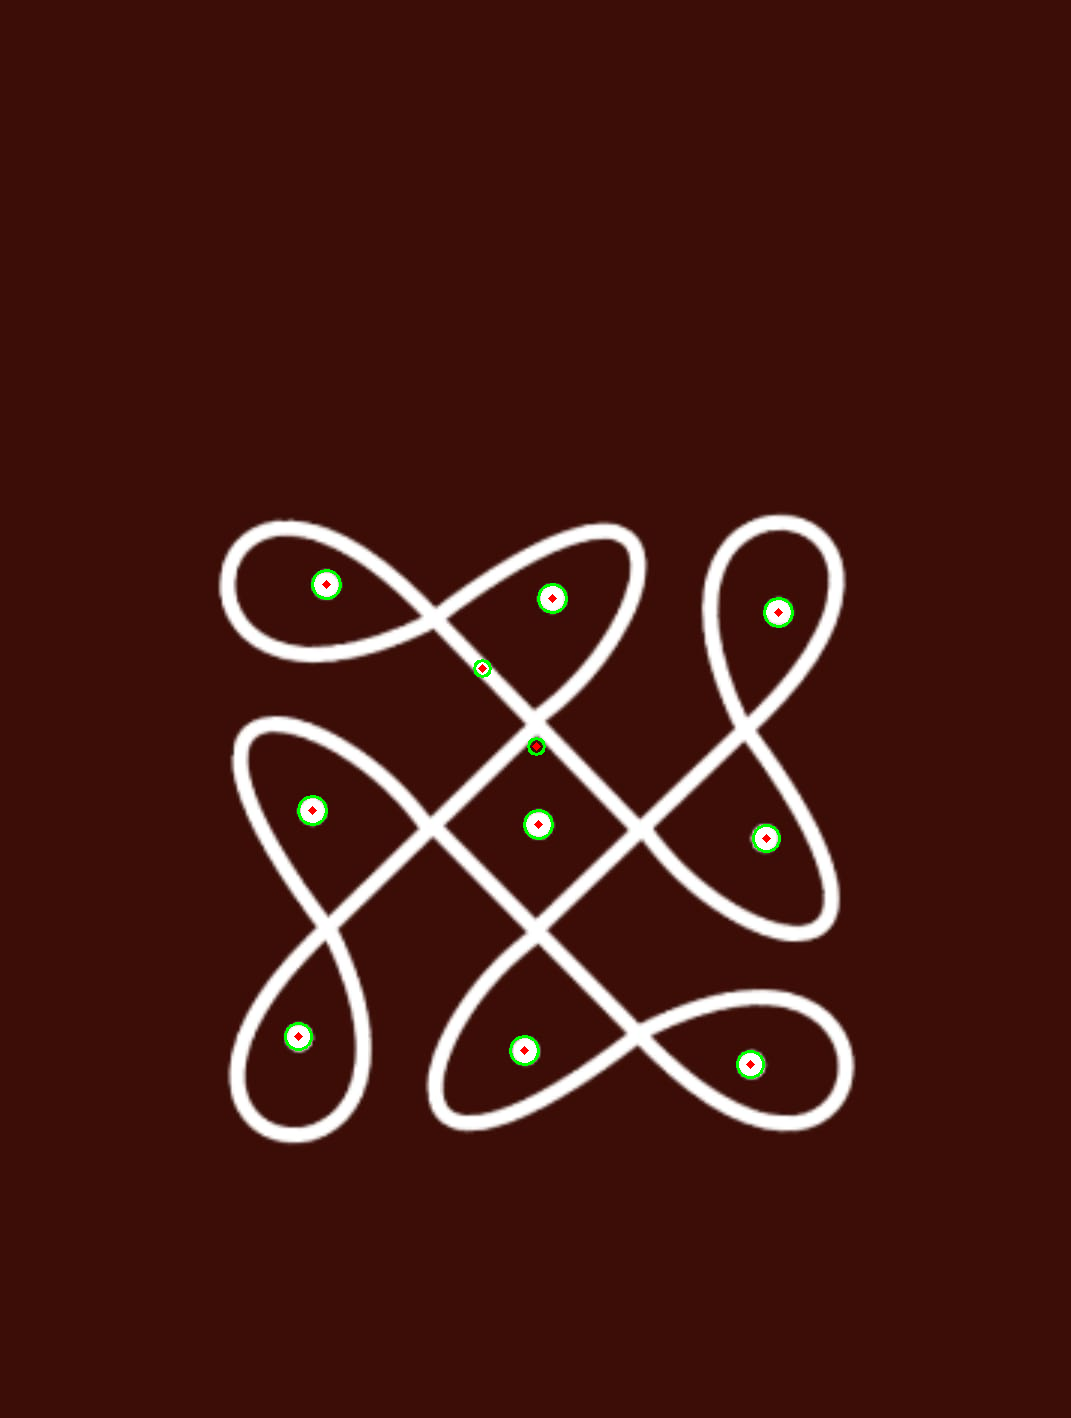

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# --- 1. Load the original and grayscale images ---
# Make sure the filename is correct
filename = '1.jpg'
img = cv2.imread(filename)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if img is not None:
    # --- 2. Detect Circles using Hough Circle Transform ---
    # This function's parameters may need tuning for different images.
    # minDist: Minimum distance between the centers of detected circles.
    # param1: Upper threshold for the internal Canny edge detector.
    # param2: Threshold for center detection.
    # minRadius, maxRadius: The range of circle sizes to look for.
    circles = cv2.HoughCircles(gray_img,
                               cv2.HOUGH_GRADIENT,
                               dp=1,
                               minDist=20,
                               param1=50,
                               param2=12, # Lower this value to detect more, weaker circles
                               minRadius=5,
                               maxRadius=15)

    # --- 3. Draw the Detected Circles ---
    if circles is not None:
        # Convert the circle parameters (x, y, radius) to integers
        circles = np.uint16(np.around(circles))

        print(f"Found {len(circles[0])} dots!")

        # Loop over all detected circles and draw them on the original image
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2) # Green circle
            # Draw the center of the circle
            cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3) # Red dot

        # --- 4. Display the result ---
        print("\nDetected Dots:")
        cv2_imshow(img)
    else:
        print("No dots were found. You might need to adjust the parameters in cv2.HoughCircles.")

else:
    print(f"Error: Could not read the image file '{filename}'.")

Skeleton of the Kolam lines:


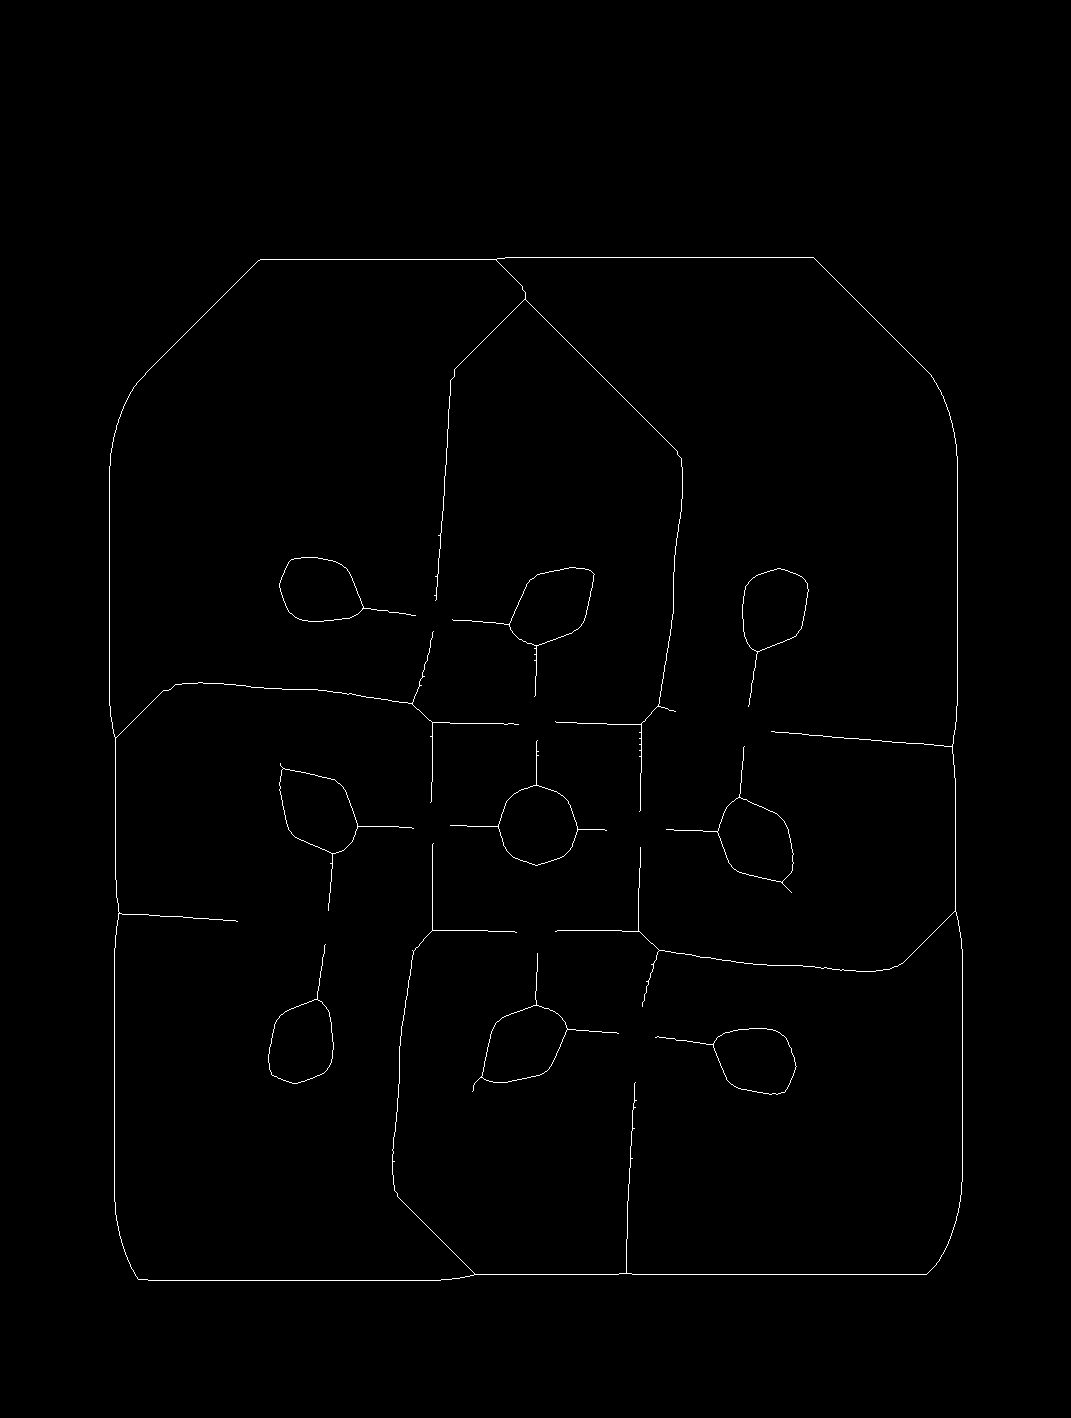

In [4]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.morphology import skeletonize

# --- 1. Read and preprocess the image ---
filename = '1.jpg'
img = cv2.imread(filename)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# We need the inverted binary image from our preprocessing step
# Note: The threshold value might need slight adjustment
_, binary_img_inv = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV)

# The skeletonize function needs the image pixel values to be 0 or 1.
binary_img_skel = binary_img_inv / 255

# --- 2. Perform Skeletonization ---
# This algorithm thins the lines to a single pixel width.
skeleton = skeletonize(binary_img_skel)

# --- 3. Display the result ---
# Convert the skeleton back to a format that can be displayed
skeleton_img = (skeleton * 255).astype(np.uint8)
print("Skeleton of the Kolam lines:")
cv2_imshow(skeleton_img)

Cleaned Black and White Image:


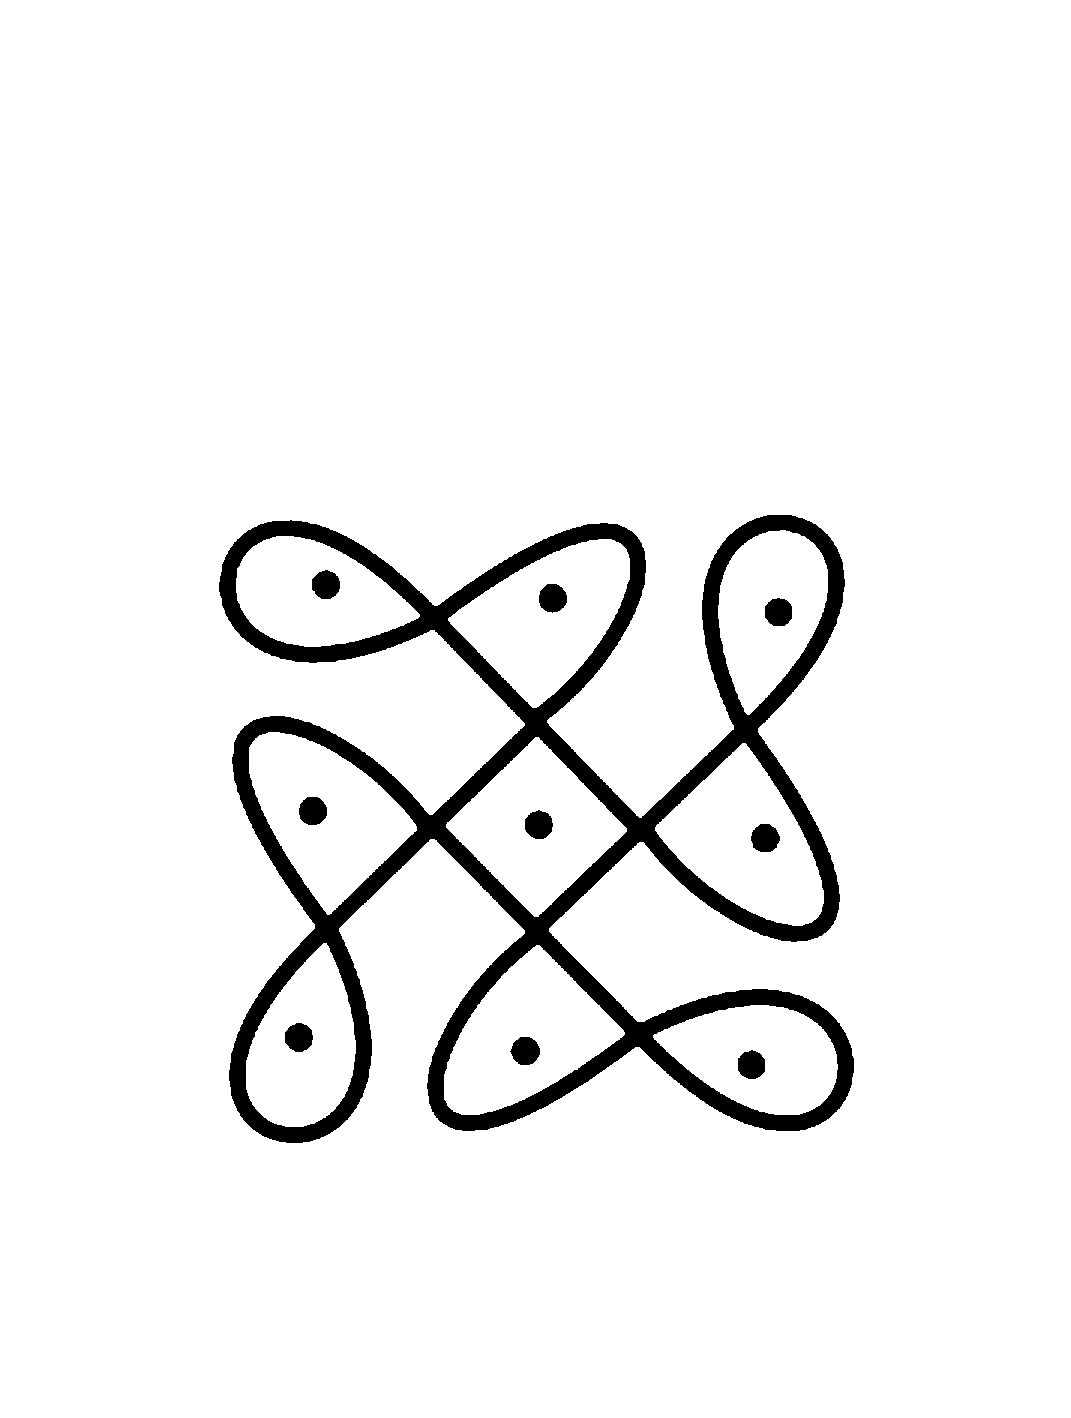


Cleaner Skeleton:


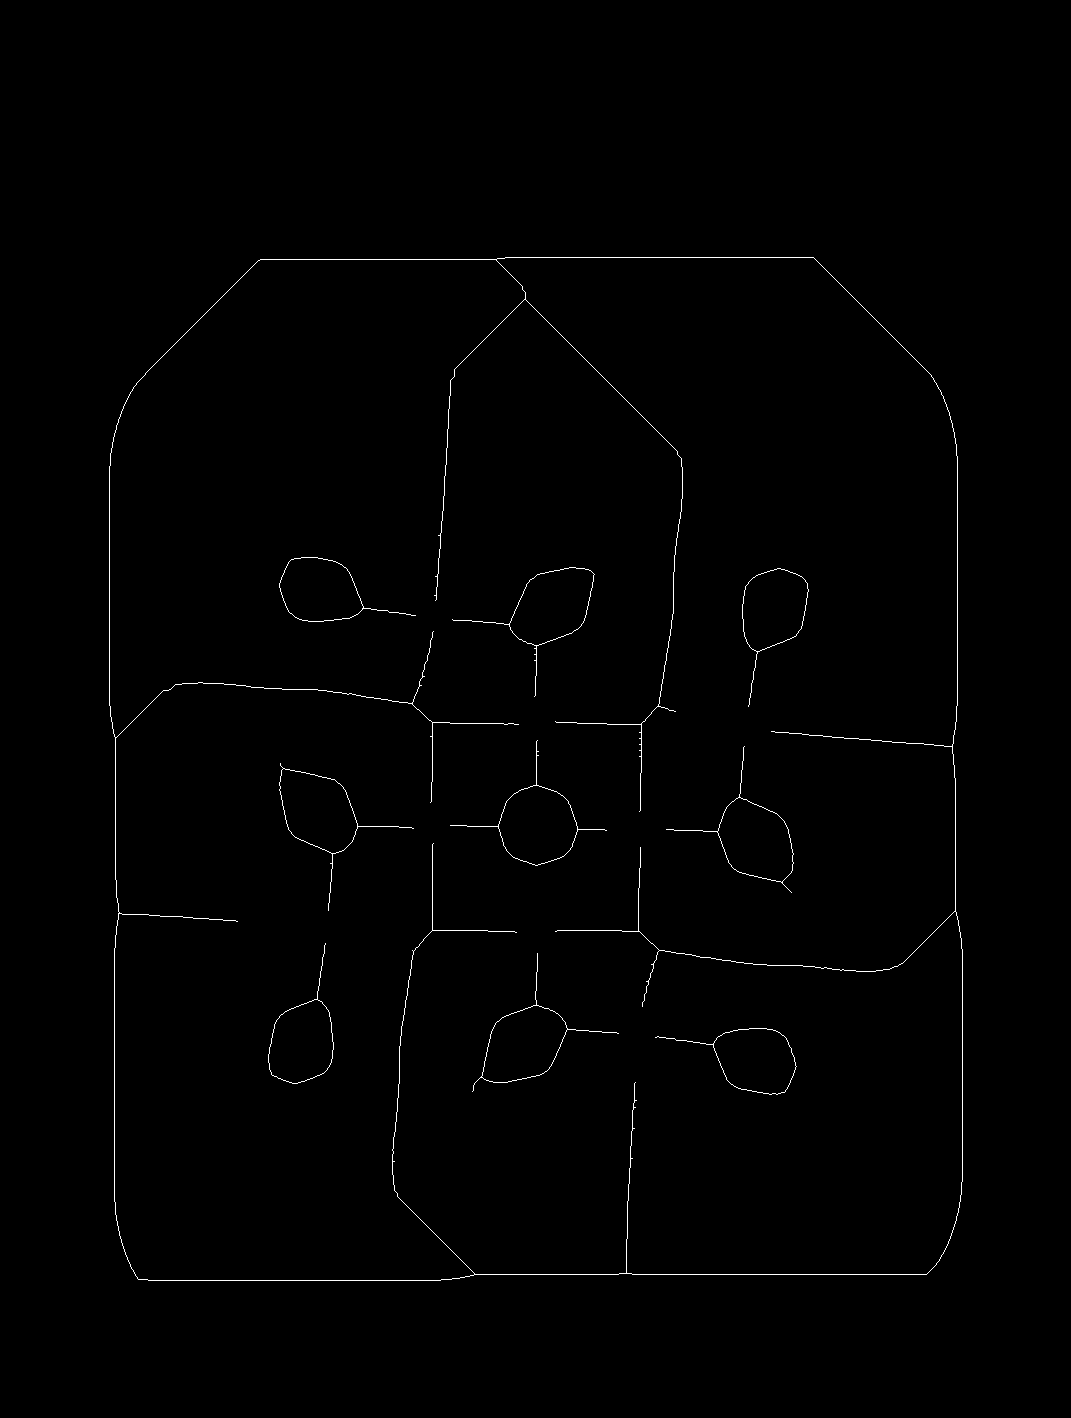


Analysis complete! Found 273 nodes and 143 paths.


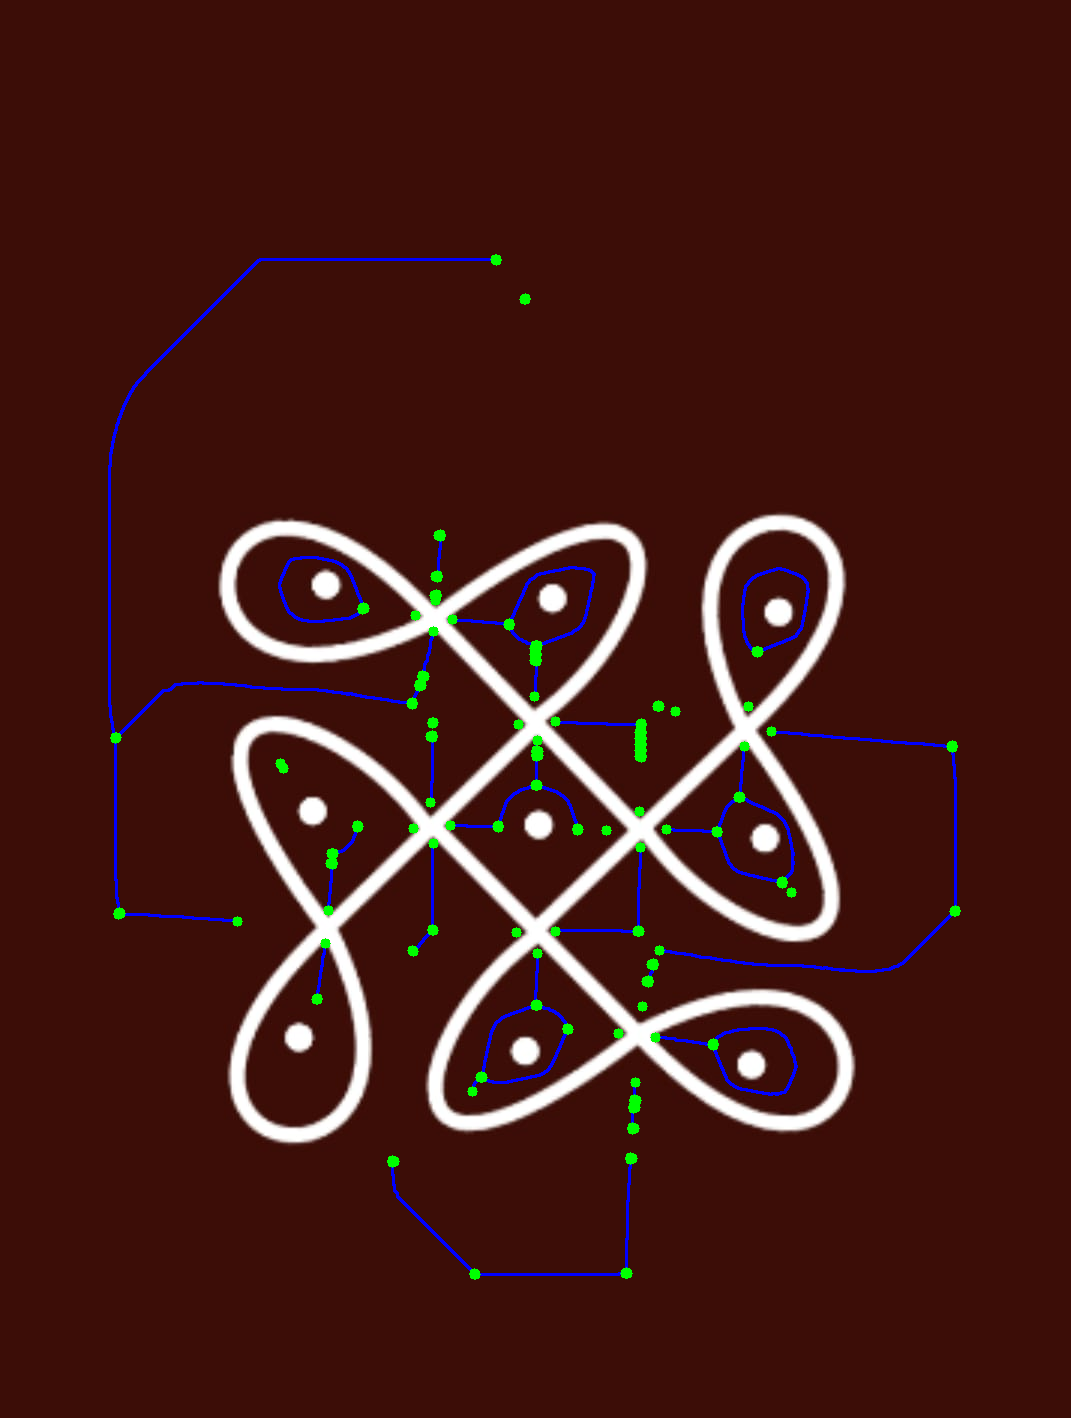

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage.morphology import skeletonize
from collections import deque

# --- (Code from previous steps) ---
filename = '1.jpg'
img = cv2.imread(filename)
original_img_for_drawing = img.copy() # Make a copy for the final drawing
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary_img_inv = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV)

# --- NEW: Clean the Binary Image ---
# This kernel will be used for cleaning
kernel = np.ones((3,3), np.uint8)
# Erode to remove noise
eroded_img = cv2.erode(binary_img_inv, kernel, iterations=1)
# Dilate to close gaps
cleaned_img = cv2.dilate(eroded_img, kernel, iterations=1)
print("Cleaned Black and White Image:")
cv2_imshow(cleaned_img)


# --- Perform Skeletonization on the CLEANED image ---
binary_img_skel = cleaned_img / 255
skeleton = skeletonize(binary_img_skel).astype(np.uint8)
print("\nCleaner Skeleton:")
cv2_imshow(skeleton * 255)


# --- 1. Find Nodes (endpoints and junctions) ---
conv_kernel = np.uint8([[1,1,1],[1,0,1],[1,1,1]])
neighbors = cv2.filter2D(skeleton, -1, conv_kernel)
nodes = np.where((neighbors != 2) & (skeleton == 1))
node_pixels = list(zip(nodes[0], nodes[1]))

# --- 2. Trace paths between nodes ---
paths = []
visited = np.zeros_like(skeleton)
for r, c in node_pixels:
    if visited[r, c] == 0:
        q = deque([(r, c, [(r, c)])])
        visited[r, c] = 1
        while q:
            curr_r, curr_c, path = q.popleft()
            for dr in [-1, 0, 1]:
                for dc in [-1, 0, 1]:
                    if dr == 0 and dc == 0: continue
                    next_r, next_c = curr_r + dr, curr_c + dc
                    if 0 <= next_r < skeleton.shape[0] and 0 <= next_c < skeleton.shape[1] \
                       and skeleton[next_r, next_c] == 1 and visited[next_r, next_c] == 0:
                        visited[next_r, next_c] = 1
                        new_path = path + [(next_r, next_c)]
                        if (next_r, next_c) in node_pixels:
                            paths.append(new_path)
                        else:
                            q.append((next_r, next_c, new_path))

# --- 3. Visualize the final graph ---
print(f"\nAnalysis complete! Found {len(node_pixels)} nodes and {len(paths)} paths.")
for path in paths:
    for i in range(len(path) - 1):
        p1 = (path[i][1], path[i][0])
        p2 = (path[i+1][1], path[i+1][0])
        cv2.line(original_img_for_drawing, p1, p2, (255, 0, 0), 2)
for r, c in node_pixels:
    cv2.circle(original_img_for_drawing, (c, r), 5, (0, 255, 0), -1)
cv2_imshow(original_img_for_drawing)

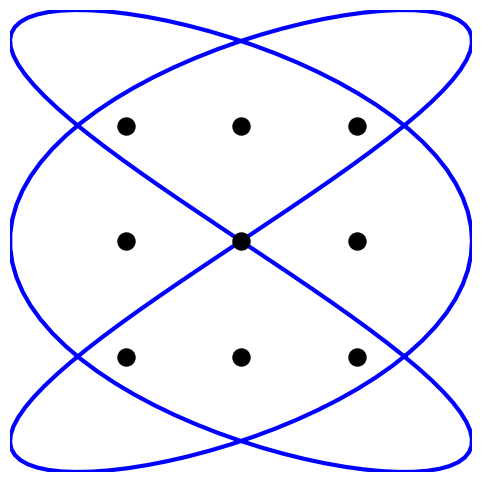

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches

# --- 1. Define the Kolam's Path using a Lissajous curve ---
def lissajous_path(grid_size, a, b, delta, num_points=200):
    """Generates a path similar to a Kolam."""
    t = np.linspace(0, 2 * np.pi, num_points)
    x = (grid_size / 2) * np.sin(a * t + delta) + (grid_size / 2)
    y = (grid_size / 2) * np.sin(b * t) + (grid_size / 2)
    return list(zip(x, y))

# Parameters that create a Kolam-like pattern for a 3x3 grid
GRID_SIZE = 4
path_points = lissajous_path(GRID_SIZE, 3, 2, np.pi/2)


# --- 2. Setup the Plot ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
plt.axis('off')

# --- 3. Draw the Smooth Path ---
if path_points:
    # Define the sequence of moves for the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(path_points) - 1)

    # *** THIS IS THE FIX ***
    # Create the Path object with the points and the codes
    path = Path(path_points, codes)

    patch = patches.PathPatch(path, facecolor='none', edgecolor='blue', lw=3)
    ax.add_patch(patch)


# --- 4. Draw the Dots (Pulli) ---
dots_x = [1, 2, 3, 1, 2, 3, 1, 2, 3]
dots_y = [1, 1, 1, 2, 2, 2, 3, 3, 3]
ax.scatter(dots_x, dots_y, color='black', s=150, zorder=10)

ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
plt.show()

Please upload your Kolam image.


Saving 1.jpg to 1 (1).jpg

--- AI Analyzing Input: '1 (1).jpg' ---
Analysis complete: Found 10 potential dots, assuming a 3x3 grid.
Generating a 3x3 Kolam...
No traditional pattern for 3x3. Using 'Lissajous' fallback style.


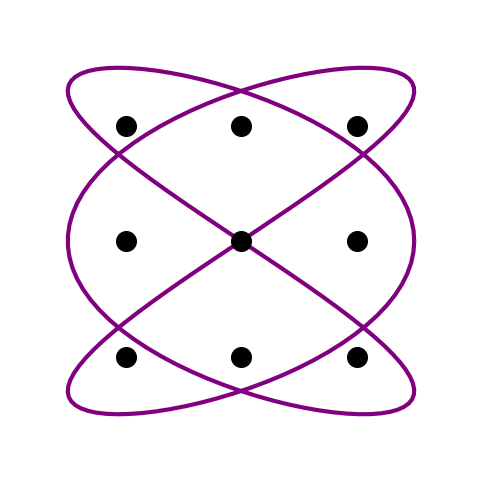

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow
from matplotlib.path import Path
import matplotlib.patches as patches

# ==============================================================================
# Part 1: The Analyzer - Robust grid detection.
# ==============================================================================
def find_grid_size_from_image(img_path):
    """Analyzes an image to find the number of dots and determine the grid size."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    blurred_img = cv2.medianBlur(img, 5)
    circles = cv2.HoughCircles(blurred_img, cv2.HOUGH_GRADIENT, dp=1, minDist=30,
                               param1=60, param2=20, minRadius=8, maxRadius=30)
    if circles is not None:
        num_dots = len(circles[0])
        grid_size = int(round(np.sqrt(num_dots)))
        print(f"Analysis complete: Found {num_dots} potential dots, assuming a {grid_size}x{grid_size} grid.")
        return grid_size
    return None

# ==============================================================================
# Part 2: The Generator - With a smart fallback for any grid size.
# ==============================================================================
def generate_kolam_pattern(grid_size):
    """Generates a Kolam based on the provided grid size."""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal')
    plt.axis('off')
    print(f"Generating a {grid_size}x{grid_size} Kolam...")

    if grid_size == 2:
        # For a 2x2 grid, use the reliable interwoven pattern
        print("Using 'Traditional Interwoven' style for 2x2 grid.")
        def draw_arc(center_x, center_y, radius, start, end, color="blue"):
            angles = np.linspace(np.radians(start), np.radians(end), 100)
            x = center_x + radius * np.cos(angles)
            y = center_y + radius * np.sin(angles)
            ax.plot(x, y, color=color, linewidth=3)

        draw_arc(1.5, 2, 0.5, 0, 180)
        draw_arc(1.5, 1, 0.5, 180, 360)
        draw_arc(1, 1.5, 0.5, 90, 270)
        draw_arc(2, 1.5, 0.5, -90, 90)
    else:
        # For any other grid size, use the creative Lissajous pattern as a fallback
        print(f"No traditional pattern for {grid_size}x{grid_size}. Using 'Lissajous' fallback style.")
        def lissajous_path(gs, a, b, delta, num_points=200):
            t = np.linspace(0, 2 * np.pi, num_points)
            x = (gs / 2) * np.sin(a * t + delta) + (gs / 2) + 0.5
            y = (gs / 2) * np.sin(b * t) + (gs / 2) + 0.5
            return list(zip(x, y))

        path_points = lissajous_path(grid_size, a=grid_size, b=grid_size-1, delta=np.pi/2)
        if path_points:
            codes = [Path.MOVETO] + [Path.LINETO] * (len(path_points) - 1)
            path = Path(path_points, codes)
            patch = patches.PathPatch(path, facecolor='none', edgecolor='purple', lw=3)
            ax.add_patch(patch)

    # Draw the dots for the grid
    dot_coords = np.arange(1, grid_size + 1)
    dots_x, dots_y = np.meshgrid(dot_coords, dot_coords)
    ax.scatter(dots_x, dots_y, color='black', s=200, zorder=10)
    ax.set_xlim(0, grid_size + 1)
    ax.set_ylim(0, grid_size + 1)
    plt.show()

# ==============================================================================
# Part 3: The Main Program Flow
# ==============================================================================
def run_ai_kolam_system():
    print("Please upload your Kolam image.")
    uploaded = files.upload()
    if len(uploaded.keys()) > 0:
        filename = list(uploaded.keys())[0]
        print(f"\n--- AI Analyzing Input: '{filename}' ---")
        detected_grid_size = find_grid_size_from_image(filename)
        if detected_grid_size:
            generate_kolam_pattern(detected_grid_size)
        else:
            print("Cannot generate Kolam as grid size could not be determined from input.")
    else:
        print("No file uploaded.")

# --- Run the full AI system ---
run_ai_kolam_system()